In [1]:
# %reset -f
%config Completer.use_jedi = True
# %matplotlib widget


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os,glob,sys,importlib,pickle
from itertools import combinations#,scipy,coolbox,pybedtools,
# from scipy.stats import linregress
# from scipy.ndimage import gaussian_filter
# from tqdm import tqdm
from IPython.display import Image
import pandas as pd
import seaborn as sns
from scipy import stats
import networkx as nx
# import pyvis
# from pyvis.network import Network
import networkit as nk
# import biosppy
# from sklearn import metrics

def load_list_of_dicts(filename, create_using=nx.Graph):
    with open(filename, 'rb') as f:
        list_of_dicts = pickle.load(f)   
    graphs = [create_using(graph) for graph in list_of_dicts]
    return graphs

os.chdir('/home/dcmorgan')
os.getcwd()

'/home/dcmorgan'

# bioinfo > net

In [33]:
R0396MWT=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t',usecols=[0,1])
R0396MWT=R0396MWT[R0396MWT['R0003-CPK-DNA_Abundance-RPKs']!=0]

In [39]:
# R0396MWT['gene']=R0396MWT['# Gene Family'].str.split('|').str[0].str.split('_').str[1].tolist()
# R0396MWT['spec']=R0396MWT['# Gene Family'].str.split('|').str[1].tolist()

# R0396MWT=R0396MWT[['spec','gene']]
# R0396MWT.spec=R0396MWT.spec.astype('str')


R0396MWTa=R0396MWT.loc[np.random.choice(R0396MWT.index, 5000, replace=False)]

In [40]:
[len(np.unique(R0396MWTa['spec'])),
len(np.unique(R0396MWTa['gene'].astype('str')))]

[63, 4963]

In [41]:
G=nx.from_pandas_edgelist(R0396MWTa, 'gene', 'spec', edge_attr=None, create_using=None)
# G = nx.Graph(source=['gene'],target=R0396MWT['spec'])

In [42]:
from networkx.algorithms import bipartite
# G = nx.path_graph(4)
print(bipartite.is_bipartite(G))
# is_bipartite(G)

True


In [43]:
g = nk.generators.HyperbolicGenerator(1e5).generate()
communities = nk.community.detectCommunities(g, inspect=True)

Communities detected in 0.17066 [s]
solution properties:
-------------------  -----------
# communities        4347
min community size      1
max community size   2107
avg. community size    23.0044
modularity              0.989218
-------------------  -----------


In [44]:
%%bash
pat=R0396-MWT
awk '($3>90)' run/gcn/pat/"$pat"_proteins_o2 > "$pat"_nko
cut -f2 "$pat"_nko |cut -d "|" -f 1|cut -d "_" -f 2 > "$pat"_tmpA
cut -f2 "$pat"_nko |cut -d "|" -f 2 > "$pat"_tmpB
cut -f3 "$pat"_nko >"$pat"_tmpC
pr -mt -s, "$pat"_tmpB "$pat"_tmpA "$pat"_tmpC >"$pat"_nk
# awk '($3>90)' "$pat"_tmpD >"$pat"_nk
rm *tmp*

Process is interrupted.


In [75]:
reader = nk.graphio.EdgeListReader(',',1,'#',directed=False,continuous=False)
G = reader.read('R0396-MWT_nk')
map = reader.getNodeMap()


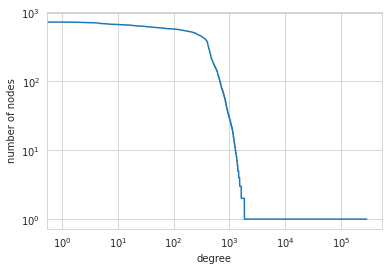

In [76]:
dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [ ]:
nk.profiling.Profile.create(G).output('pdf','tmp')

In [111]:
plmCommunities = nk.community.detectCommunities(G, algo=nk.community.PLM(G, True))

Communities detected in 0.22767 [s]
solution properties:
-------------------  -----------
# communities        2401
min community size      2
max community size    744
avg. community size   120.827
modularity              0.998501
-------------------  -----------


In [114]:
print("{0} elements assigned to {1} subsets".format(plmCommunities.numberOfElements(),
plmCommunities.numberOfSubsets()))
nk.community.writeCommunities(plmCommunities, "tmp/communtiesPLM.partition")

290105 elements assigned to 2401 subsets
wrote communities to: tmp/communtiesPLM.partition


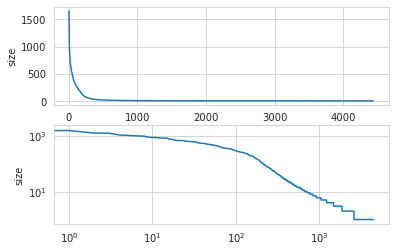

In [115]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

In [ ]:
coreDec = nk.centrality.CoreDecomposition(g)
coreDec.run()
nk.viztasks.drawGraph(g, node_size=[(k**2)*20 for k in coreDec.scores()])
plt.show()

# pheno

In [5]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [8]:
# unibact=pd.DataFrame(glob.glob("run/gcn/pat/*_nk"))[0].str.split('/').str[3].str.split('-').str[0].tolist()

In [9]:
# PP=primary[primary.index.isin(unibact)]



In [7]:
uni_bact=primary[['Age','Hypertension Category by 24h BP w/o considering antihypertensive med']]
uni_bact=uni_bact.rename(columns={"Hypertension Category by 24h BP w/o considering antihypertensive med": "HT"})

In [18]:
# sub_uni=unibact[primary.index[primary.index.isin(unibact)]]
# sub_uni=PP[['Age','Hypertension Category by 24h BP w/o considering antihypertensive med']]


In [63]:
# nets=glob.glob('run/gcn/pat/*_nk')
# net=pd.read_csv(nets[1],header=None)

In [ ]:
# !cut -f1 run/gcn/pat/R0413-LMF_nk_t | taxonkit lineage | taxonkit reformat -r "Unassigned" -f "{k}\t{p}\t{c}\t{o}\t{f}\t{g}\t{s}\t{t}" | cut -f 1,3-10>tmp.txt

# build code on 50 subset

In [16]:
# relab=pd.read_csv('../../groups/cgsd/gordonq/all_hypertension/342_K2_contigsum.csv')
# relab[['p', 'c','o','f','g','s']]=pd.DataFrame(relab["Unnamed: 0"].str.split(';', expand=True).values,
#              columns=['p', 'c','o','f','g','s'])
# del relab["Unnamed: 0"]
relgene=pd.read_csv('/groups/cgsd/gordonq/LauG_Metagenomics_CPOS-200710-CJX-3455a/50_genefamilies.tsv',sep='\t')
# relgene=pd.read_csv('50_genefamilies-cpm.tsv')
# relgene=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t',nrows=100)

relgene['gene']=relgene['# Gene Family'].str.split('|').str[0]
relgene=relgene[relgene['gene']!='UniRef90_unknown']
relgene=relgene[relgene['gene']!='UNMAPPED']
relgene.index=relgene['# Gene Family']
del relgene['gene'], relgene['# Gene Family']
# relgene=relgene/relgene.sum(axis=0)

# relgene=relgene/relgene.sum(axis=0)
relgene['gen']=relgene.index.str.split('|').str[1].str.split('.').str[0].tolist()
relgene['spec']=relgene.index.str.split('.').str[1]#.str.split('.').str[0].tolist()
relgene['spec'].replace('_',' ')
relgene.index=relgene.index.str.split('|').str[0]
relgene=relgene.dropna()
# del relgene['# Gene Family']


In [11]:
cc=relgene.groupby(['# Gene Family','spec']).sum()
# dd=relgene.groupby(['# Gene Family','gen']).sum()
cc=cc.reset_index()
# dd=dd.reset_index()
cc=cc.rename(columns={'# Gene Family':'gene'})#,'spec':0,'gene':1})

# dd=cc[['gene','spec',net]]
# dd=dd[dd[net]!=0]

check instrucitons [from here](https://stackoverflow.com/questions/23975773/how-to-compare-directed-graphs-in-networkx#54677502)
and [here](https://stackoverflow.com/questions/18261587/python-networkx-remove-nodes-and-edges-with-some-condition)

In [78]:
relgene=pd.read_csv('data/gcn/relgene_other.txt',sep='\t')

In [12]:
from networkx.algorithms import bipartite
ff=[]
C=[]
for i,net in enumerate(relgene.columns[1:-2]):
    pd.read_csv()
    dd=cc[['spec','gene',net]]
    dd=dd[dd[net]!=0]
    ee=nx.from_pandas_edgelist(dd,source='spec',target='gene')
    remove = [node for node,degree in dict(ee.degree()).items() if degree <10]
    ee.remove_nodes_from(remove)
    ff.append(ee)
    
    B = nx.Graph()
    B.add_nodes_from(dd['spec'], bipartite=0)
    B.add_nodes_from(dd['gene'], bipartite=1)
    B.add_edges_from(tuple(dd[['spec','gene']].itertuples(index=False, name=None)))
    remove = [node for node,degree in dict(B.degree()).items() if degree <10]
    B.remove_nodes_from(remove)
    C.append(B)

with open('data/gcn/NX_all_hypert.pkl', 'wb') as f:
    pickle.dump(ff, f)
with open('data/gcn/BX_all_hypert.pkl', 'wb') as f:
    pickle.dump(C, f)

In [155]:
graphs = load_list_of_dicts('data/gcn/BX_all100_hypert.pkl')
len(graphs[0].edges())
# B=graphs[3]
# remove = [node for node,degree in dict(B.degree()).items() if degree <2]
# B.remove_nodes_from(remove)
# len(B.edges)

0

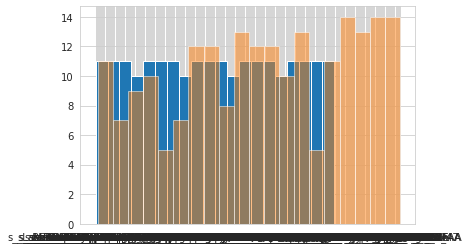

In [10]:
measur=eval('nx.degree_centrality')
tmp=plt.hist(measur(graphs[1]),bins=20)
tmp=plt.hist(measur(graphs[0]),bins=20,alpha=.5)

In [16]:
HT50=uni_bact[uni_bact.index.isin(relgene.columns[:-2].str.split('-').str[0])]
HT50['index']=np.arange(len(HT50))
S = [nx.clustering(graphs[i]) for i in HT50[HT50['HT']==0]['index'].values]
T = [nx.clustering(graphs[i]) for i in HT50[HT50['HT']!=0]['index'].values]

/tmp/ipykernel_49002/3471001399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HT50['index']=np.arange(len(HT50))


In [17]:
non=pd.DataFrame(S).melt()
non['type']='NoHT'
non.dropna(inplace=True)
non=non[non.value!=0]
non=non[~non['variable'].str.contains('UniRef90')]
non.value=non.value/np.sum(non.value)
yes=pd.DataFrame(T).melt()
yes['type']='HT'
yes.dropna(inplace=True)
yes=yes[yes.value!=0]
yes=yes[~yes['variable'].str.contains('UniRef90')]
yes.value=yes.value/np.sum(yes.value)
df=non.append(yes)
# df=df.dropna()
df['gen']=df.variable.str.split('_').str[2]

In [18]:
[sum(non.value),sum(yes.value)]

[0, 0]

/home/dcmorgan/.conda/envs/mypy3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


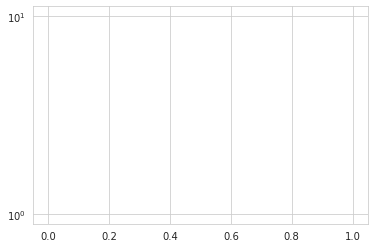

In [14]:
tmp=plt.hist(non.value,log=True,bins=100)
tmp=plt.hist(yes.value,log=True,bins=100,alpha=.5)

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df[df['type']=='HT'], row="gen", hue="gen", aspect=20, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "value")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.savefig("data/gcn/degree_centrality_HT.png",dpi=300,bbox_inches = "tight")


In [ ]:
relgene=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t')

relgene['gene']=relgene['# Gene Family'].str.split('|').str[0]
relgene=relgene[relgene['gene']!='UniRef90_unknown']
relgene=relgene[relgene['gene']!='UNMAPPED']
relgene.index=relgene['# Gene Family']
del relgene['gene'], relgene['# Gene Family']
# relgene=relgene/relgene.sum(axis=0)
relgene=relgene/relgene.sum(axis=0)
relgene['gen']=relgene.index.str.split('|').str[1].str.split('.').str[0].tolist()
relgene['spec']=relgene.index.str.split('.').str[1]#.str.split('.').str[0].tolist()
relgene['spec'].replace('_',' ')
relgene.index=relgene.index.str.split('|').str[0]
relgene=relgene.dropna()


cc=relgene.groupby(['# Gene Family','spec']).sum()
# dd=relgene.groupby(['# Gene Family','gen']).sum()
cc=cc.reset_index()
# dd=dd.reset_index()
cc=cc.rename(columns={'# Gene Family':'gene'})#,'spec':0,'gene':1})


primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
uni_bact=primary[['Age','Hypertension Category by 24h BP w/o considering antihypertensive med']]
uni_bact=uni_bact.rename(columns={"Hypertension Category by 24h BP w/o considering antihypertensive med": "HT"})


# run on entire hypertension pop

In [ ]:
# %%bash 
# humann_join_tables -i /groups/cgsd/gordonq/hypertension_all/humann3_res -o hmp_subset_genefamilies.tsv --file_name genefamilies
# humann_renorm_table -i hmp_subset_genefamilies.tsv -o hmp_subset_genefamilies-cpm.tsv --units cpm

Problem opening file: hmp_subset_genefamilies.tsv


In [303]:
sys.path.insert(1, './run/gcn/')
import gcn_func
importlib.reload(sys.modules['gcn_func'])
from gcn_func import bip, load_list_of_dicts, meas, plotRidge

In [354]:
def load_list_of_dicts(filename, create_using=nx.Graph):
    with open(filename, 'rb') as f:
        list_of_dicts = pickle.load(f)   
    # graphs = [create_using(graph) for graph in list_of_dicts]
    return list_of_dicts

In [356]:
graphs = load_list_of_dicts('data/gcn/BX_'+patt+'_hypert.pkl')

In [279]:
with open('data/gcn/BX_'+str(patt)+'_hypert.pkl', 'ab+') as f:
    pickle.dump(C, f)

In [311]:
ff=[]
C=[]
# from joblib import Parallel
# dd=relgene.columns[relgene.columns.str.contains('RPKs')]
ff=Parallel(n_jobs=48) (bip(cc,net,ff,C,patt) for i,net in enumerate(dd[1:5]))

In [317]:
ff[0]

([<networkx.classes.graph.Graph at 0x7fedf1c4a490>],
 [<networkx.classes.graph.Graph at 0x7fedf1c4a130>])

In [331]:
ff[0][0]

In [332]:
[tup[0] for tup in ff]

[[<networkx.classes.graph.Graph at 0x7fedf1c4a490>],

In [333]:
ff

[([<networkx.classes.graph.Graph at 0x7fedf1c4a490>],
  [<networkx.classes.graph.Graph at 0x7fedf1c4a130>]),
 ([<networkx.classes.graph.Graph at 0x7fedbd65ee80>],
  [<networkx.classes.graph.Graph at 0x7fedeff5fc10>]),
 ([<networkx.classes.graph.Graph at 0x7fedfe1d6310>],
  [<networkx.classes.graph.Graph at 0x7fedefe8b610>]),
 ([<networkx.classes.graph.Graph at 0x7fedeff5ffd0>],
  [<networkx.classes.graph.Graph at 0x7fedeeee6130>])]